In [2]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
import seaborn as sns
#import pyfolio
import datetime
from sklearn.cluster import MeanShift, estimate_bandwidth
%matplotlib inline

In [3]:
def load_symbol(filename):
# Load symbol and get quotes, datetimes and volumes
    df_cur = pd.read_csv(filename)
    cur_col1 = df_cur.iloc[:, 4].values
    cur_index = df_cur.iloc[:, 0].values
    cur_volume = df_cur.iloc[:, 5].values
    
    return cur_col1, cur_index, cur_volume

def drop_zeros(index, rates, volume):
# Drops weekend values
    jj = 0
    for j in range(len(volume)):
        if volume[j] > 0:
            rates[jj] = rates[j]
            index[jj] = index[j]
            volume[jj] = volume[j]
            jj += 1

    rates = rates[:jj]
    index = index[:jj]
    volume = volume[:jj]

    return rates, index, volume

In [91]:
rates_1, index_1, volume_1 = load_symbol('data/EURAUD_Candlestick_15_m_BID_01.01.2015-24.06.2017.csv')
#rates_1, index_1, volume_1 = load_symbol('data/2012-2017_EU_M15.csv')
#rates_1, index_1, volume_1 = load_symbol('data/EURAUD_Candlestick_5_m_BID_02.01.2012-26.06.2017.csv')
#rates_1, index_1, volume_1 = load_symbol('data/EURAUD_Candlestick_4_h_BID_02.01.2006-08.07.2017.csv')
rates_1, index_1, volume_1 = drop_zeros(index_1, rates_1, volume_1)

rates_2, index_2, volume_2 = load_symbol('data/EURUSD_Candlestick_15_m_BID_01.01.2015-24.06.2017.csv')
#rates_2, index_2, volume_2 = load_symbol('data/2012-2017_EA_M15.csv')
#rates_2, index_2, volume_2 = load_symbol('data/EURNOK_Candlestick_5_m_BID_02.01.2012-24.06.2017.csv')
#rates_2, index_2, volume_2 = load_symbol('data/EURCHF_Candlestick_4_h_BID_02.01.2006-08.07.2017.csv')
rates_2, index_2, volume_2 = drop_zeros(index_2, rates_2, volume_2)

rates_3, index_3, volume_3 = load_symbol('data/EURNZD_Candlestick_15_m_BID_01.01.2015-24.06.2017.csv')
#rates_3, index_3, volume_3 = load_symbol('data/2012-2017_EN_M15.csv')
#rates_3, index_3, volume_3 = load_symbol('data/EURUSD_Candlestick_5_m_BID_02.01.2012-26.06.2017.csv')
#rates_3, index_3, volume_3 = load_symbol('data/EURUSD_Candlestick_4_h_BID_02.01.2006-08.07.2017.csv')
rates_3, index_3, volume_3 = drop_zeros(index_3, rates_3, volume_3)

rates_4, index_4, volume_4 = load_symbol('data/EURNOK_Candlestick_15_m_BID_01.01.2015-24.06.2017.csv')
#rates_3, index_3, volume_3 = load_symbol('data/2012-2017_EN_M15.csv')
#rates_3, index_3, volume_3 = load_symbol('data/EURUSD_Candlestick_5_m_BID_02.01.2012-26.06.2017.csv')
#rates_3, index_3, volume_3 = load_symbol('data/EURUSD_Candlestick_4_h_BID_02.01.2006-08.07.2017.csv')
rates_4, index_4, volume_4 = drop_zeros(index_4, rates_4, volume_4)

rates_5, index_5, volume_5 = load_symbol('data/EURCHF_Candlestick_15_m_BID_01.01.2015-24.06.2017.csv')
#rates_5, index_5, volume_5 = load_symbol('data/EURGBP_Candlestick_15_m_BID_01.01.2015-24.06.2017.csv')
#rates_3, index_3, volume_3 = load_symbol('data/2012-2017_EN_M15.csv')
#rates_3, index_3, volume_3 = load_symbol('data/EURUSD_Candlestick_5_m_BID_02.01.2012-26.06.2017.csv')
#rates_3, index_3, volume_3 = load_symbol('data/EURUSD_Candlestick_4_h_BID_02.01.2006-08.07.2017.csv')
rates_5, index_5, volume_5 = drop_zeros(index_5, rates_5, volume_5)

rate_return_1 = [(rates_1[i] - rates_1[i-1])/rates_1[i-1] for i in range(1, len(rates_1))]
rate_return_2 = [(rates_2[i] - rates_2[i-1])/rates_2[i-1] for i in range(1, len(rates_2))]
rate_return_3 = [(rates_3[i] - rates_3[i-1])/rates_3[i-1] for i in range(1, len(rates_3))]
rate_return_4 = [(rates_4[i] - rates_4[i-1])/rates_4[i-1] for i in range(1, len(rates_4))]
rate_return_5 = [(rates_5[i] - rates_5[i-1])/rates_5[i-1] for i in range(1, len(rates_5))]
rate_return_1.insert(0, 0)
rate_return_2.insert(0, 0)
rate_return_3.insert(0, 0)
rate_return_4.insert(0, 0)
rate_return_5.insert(0, 0)

In [5]:
def record_open_data(type_, open_rate, entryvals, typevals, x, rates): # 0 or 1
    tradetype = type_
    trade = 1 # Keeping track of both trades simultaneously, also allows different stops/targets
    open_rate = rates[x]

    # Trades = open
    entryvals.append(x) #entryvals[ev] = x # Store position in delta array
    typevals.append(type_) # For line coloring in backtest visualization

    return trade, tradetype, open_rate, entryvals, typevals

def record_close_data(typeval, exitvals, gross_pips, x, rates, open_rate):
    if typeval == 1: 
        gross_pips.append(gross_pips[-1] + math.ceil((rates[x] - open_rate)*10000))
        #net_pips_1.append(net_pips_1[-1] + math.ceil((open_rates[0] - cur1_col1[samplesize+x])*10000))
    else:
        gross_pips.append(gross_pips[-1] + math.ceil((open_rate - rates[x])*10000))
        #net_pips_1.append(net_pips_1[-1] + math.ceil((cur1_col1[samplesize+x] - open_rates[0])*10000))
        
    trade = 0
    exitvals.append(x)
    
    return gross_pips, trade, exitvals

def sharpe_6m(net_pips, years):
    ret_ = [net_pips[i] - net_pips[i-1] for i in range(1, len(net_pips))]
    
    # trades/years/2 = trades per 6-month span
    n_6m = math.ceil(len(ret_)/years/2)
    
    trailing_mean = [np.mean(ret_[i-n_6m:i]) for i in range(n_6m, len(ret_))]
    trailing_std = [np.std(trailing_mean[i-n_6m:i]) for i in range(n_6m, len(trailing_mean))]
    
    # Compute 6 month trailing Sharpe
    sharpe_6m = [trailing_mean[i]/trailing_std[i] for i in range(len(trailing_std))]
    sharpe_avg = sum(sharpe_6m)/len(sharpe_6m)
    
    return sharpe_6m, sharpe_avg

C:\Users\Eier\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Eier\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Eier\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


final pip val: 11172.5


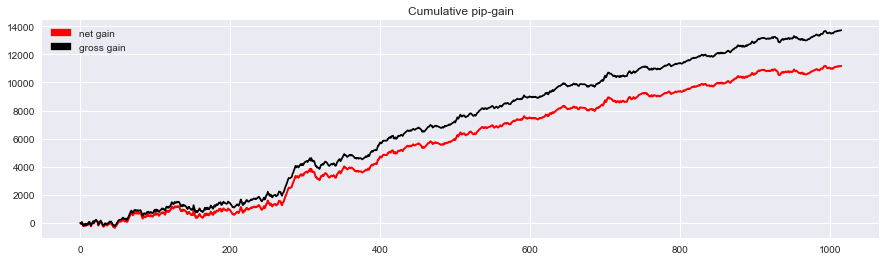

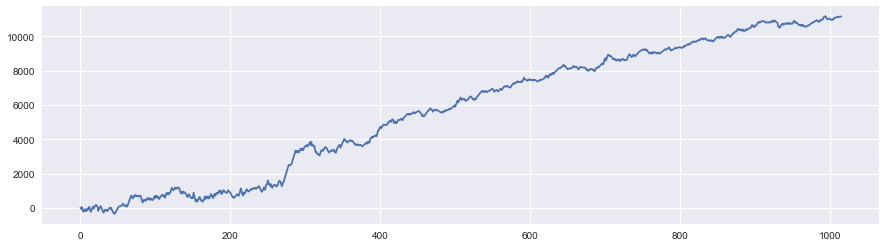

In [92]:
trade = 0
tradetype = 1
typevals = []
entryvals = []
exitvals = []
gross_pips = [0]
open_rate = 0

sigma = np.std(rate_return_1[:500])
#print('sigma', sigma)

target = sigma
stop = sigma
ma_p = 1
optimize = 0

min_len = min(len(rate_return_1), len(rate_return_2), len(rate_return_3), len(rate_return_4), len(rate_return_5))

trade_data = [[] for _ in range(14)]
sigma_data = [[] for _ in range(5)]

for x in range(1, min_len):
    
    sigma = abs(np.std(rate_return_1[x-12:x]))
    s_2 = abs(np.std(rate_return_2[x-12:x]))
    s_3 = abs(np.std(rate_return_3[x-12:x]))
    s_4 = abs(np.std(rate_return_4[x-12:x]))
    s_5 = abs(np.std(rate_return_5[x-12:x]))

    w_1 = 1#max(sigma, s_2, s_3, s_4, s_5)/sigma
    w_2 = 1#max(sigma, s_2, s_3, s_4, s_5)/s_2
    w_3 = 1#max(sigma, s_2, s_3, s_4, s_5)/s_3
    w_4 = 1#max(sigma, s_2, s_3, s_4, s_5)/s_4
    w_5 = 1#max(sigma, s_2, s_3, s_4, s_5)/s_5
    
    '''
    #
    sigma_data[0].append(w_1)
    sigma_data[1].append(w_2)
    sigma_data[2].append(w_3)
    sigma_data[3].append(w_4)
    sigma_data[4].append(w_5)
    #
    '''
    
    weighted_rr = (rate_return_2[x]*w_2 + rate_return_3[x]*w_3 + rate_return_4[x]*w_4 + rate_return_5[x]*w_5)/4
    sigma_avg = (sigma + s_2 + s_3 + s_4 + s_5)/5
    
    target = stop = np.std(rates_1[x-500:x])
    #target = stop = 4*sigma_avg
    
    # if all closed
    if trade == 0:
        if abs(rate_return_1[x]*w_1 - weighted_rr) >= 2*sigma_avg:

            # Buy (tradetype 1)
            # Weights on these are unecessary because of the binary nature of the statement
            if rate_return_1[x]*w_1 < 0 < weighted_rr:
                trade, tradetype, open_rate, entryvals, typevals = record_open_data(1, open_rate,
                                                                                    entryvals, typevals, 
                                                                                    x, rates_1)
    
            # Sell (tradetype 0)
            elif rate_return_1[x]*w_1 > 0 > weighted_rr:
                trade, tradetype, open_rate, entryvals, typevals = record_open_data(0, open_rate,
                                                                                    entryvals, typevals, 
                                                                                    x, rates_1)
                
    # if > 0 open
    else:
        
        # Buy order
        if tradetype: # == 1:
            if rates_1[x] >= open_rate + target or rates_1[x] <= open_rate - stop:
                
                # Close trade and store data
                gross_pips, trade, exitvals = record_close_data(tradetype, exitvals, 
                                                                gross_pips, x, rates_1, open_rate)
                
            if abs(rate_return_1[x]*w_1 - weighted_rr) >= 2*sigma_avg and rate_return_1[x]*w_1 >= sigma*w_1 and weighted_rr <= -sigma_avg:

                # Close trade and store data
                gross_pips, trade, exitvals = record_close_data(tradetype, exitvals, 
                                                                gross_pips, x, rates_1, open_rate)
                
                trade, tradetype, open_rate, entryvals, typevals = record_open_data(0, open_rate,
                                                                                        entryvals, typevals, 
                                                                                        x, rates_1)
                
        # Sell order
        else:
            if rates_1[x] <= open_rate - target or rates_1[x] >= open_rate + stop:
                
                # Close trade and store data
                gross_pips, trade, exitvals = record_close_data(tradetype, exitvals, 
                                                            gross_pips, x, rates_1, open_rate)
                
            elif abs(rate_return_1[x]*w_1 - weighted_rr) >= 2*sigma_avg and rate_return_1[x]*w_1 <= -sigma*w_1 and weighted_rr >= sigma_avg:

                # Close trade and store data
                gross_pips, trade, exitvals = record_close_data(tradetype, exitvals, 
                                                                gross_pips, x, rates_1, open_rate)

                trade, tradetype, open_rate, entryvals, typevals = record_open_data(1, open_rate,
                                                                                    entryvals, typevals, 
                                                                                    x, rates_1)
                              
net_pips = [gross_pips[i] - 2.5*i for i in range(len(gross_pips))]
#plt.plot(gross_pips)


if optimize:
    # Getting R^2 value
    model = LinearRegression()
    X = np.array([i for i in range(len(net_pips))]).reshape(-1, 1)
    y = net_pips
    model.fit(X, y)
    r_squared = model.score(X, y)        
    print('R^2: %.3f, pips: %.1f' % (r_squared, net_pips[-1]))

    fig = plt.figure(figsize=(10, 5))
    ccc = fig.add_subplot(111)
    plt.plot(net_pips)
    TITLENAME = 'R^2: %.4f, pips: %.1f, target: %.4f, stop: %.4f\n' % (r_squared, net_pips[-1], target, stop)

    # If score is negative e.g. loss, picture is rated by possible net if the strategy is reversed
    # Positive backtests are penalized for having low R^2-values: S*(1-R_S^2)^-1
    if net_pips[-1] <= 0:
        IMGNAME = 'data/bt_imgs/EURUSD_15m_mr/min/net_%.2f_%.1f_%.3f.png' % ((-(net_pips[-1] + 2*len(net_pips)) - 2*len(net_pips)), net_pips[-1], r_squared)
    else:
        IMGNAME = 'data/bt_imgs/EURUSD_15m_mr/max/net_%.2f_%.1f_%.3f.png' % (net_pips[-1]/(1-r_squared), net_pips[-1], r_squared)
    plt.title(TITLENAME)
    plt.savefig(IMGNAME)
    plt.close(fig)

else:     
    %matplotlib inline
    plt.figure(figsize=(15, 4))
    plt.plot(net_pips, linewidth=2.0, color='r')
    print('final pip val:', net_pips[-1])
    plt.plot(gross_pips, 'k')
    plt.title('Cumulative pip-gain')
    red_patch = mpatches.Patch(color='r', label='net gain')
    black_patch = mpatches.Patch(color='k', label='gross gain')
    plt.legend(handles=[red_patch, black_patch])
    plt.show()

    plt.figure(figsize=(15, 4))
    plt.plot(net_pips)
    plt.show()

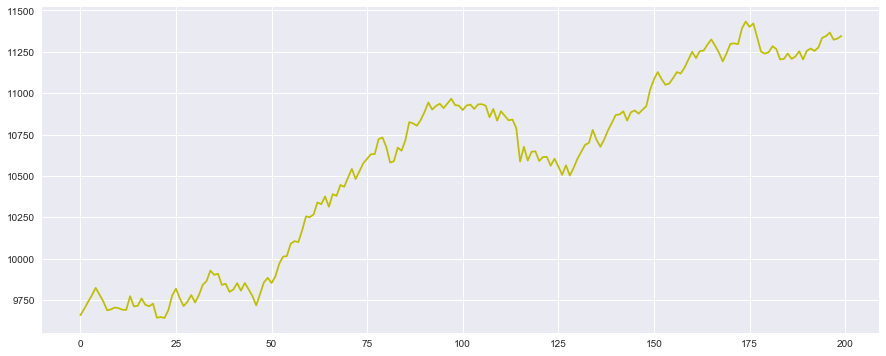

In [71]:
plt.figure(figsize=(15, 6))
plt.plot(net_pips[-200:], 'y') #usd
plt.show()

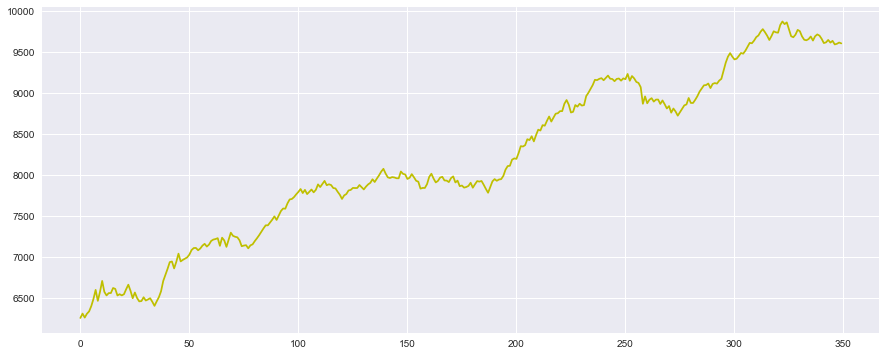

In [81]:
plt.figure(figsize=(15, 6))
plt.plot(net_pips[-350:], 'y') #usd
plt.show()

0.576201753952


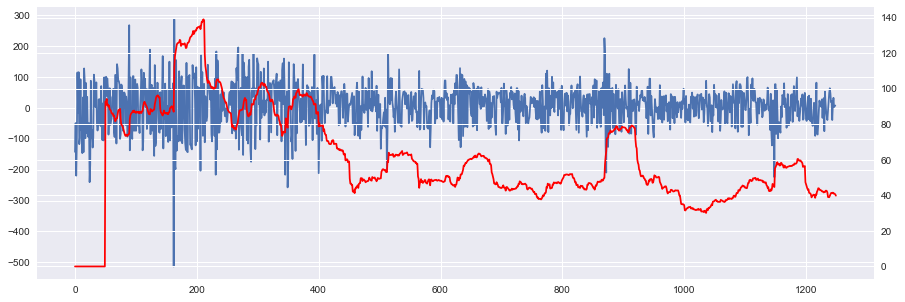

In [24]:
dnet = [net_pips[i] - net_pips[i-1] for i in range(1, len(net_pips))]
sigma_dnet = [np.std(dnet[i-50:i]) for i in range(50, len(net_pips))]
for i in range(50):
    sigma_dnet.insert(0, 0)
    
model = LinearRegression()
X = np.array([i for i in range(50, len(sigma_dnet))]).reshape(-1, 1)
y = sigma_dnet[50:]
model.fit(X, y)
print(model.score(X, y))

plt.figure(figsize=(15, 5))
plt.plot(dnet)
plt.twinx().plot(sigma_dnet, 'r')
plt.show()

In [26]:
# Create trade data dictionary
trade_data_dict = {'a_trade-return-bool':    trade_data[0],
                   'b_trade-return':         trade_data[1],
                   'c_rate-return-1':        trade_data[2],#[:-1],
                   'd_rate-return-2':        trade_data[3],#[:-1],
                   'e_rate-return-3':        trade_data[4],#[:-1],
                   'f_rate-return-return-1': trade_data[5],#[:-1],
                   'g_rate-return-return-2': trade_data[6],#[:-1],
                   'h_rate-return-return-3': trade_data[7],#[:-1],
                   'i_volume-return-1':      trade_data[8],#[:-1],
                   'j_volume-return-2':      trade_data[9],#[:-1],
                   'k_volume-return-3':      trade_data[10],#[:-1],
                   'l_volume-return-std-1':  trade_data[11],#[:-1],
                   'm_volume-return-std-2':  trade_data[12],#[:-1],
                   'o_volume-return-std-3':  trade_data[13],#[:-1]}

td_df = pd.DataFrame(trade_data_dict)
td_df.to_csv('data/trade_data_2.csv')

SyntaxError: invalid syntax (<ipython-input-26-59b2159d086c>, line 17)

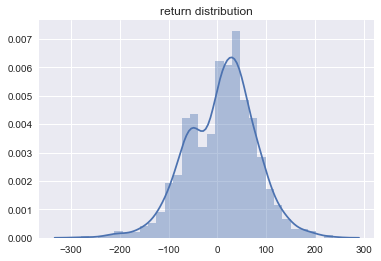

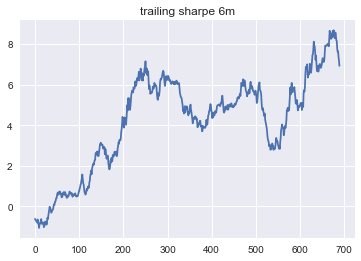

std		 69.2574543871
stdmax		 3.41 deviations
mean		 8.41470844212
median		 14.5
skewness	 -0.27129
kurtosis	 0.4678662940337128
win rate	 0.6
mean sharpe	 4.22058422369
current sharpe	 6.92493604232


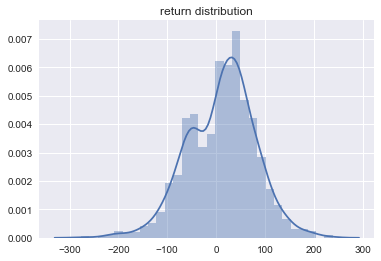

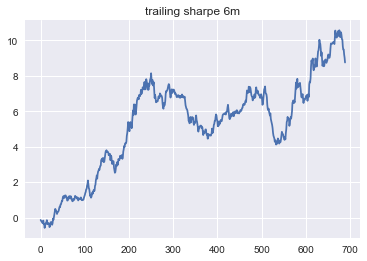

std		 69.2574543871
stdmax		 3.45 deviations
mean		 10.9147084421
median		 17.0
skewness	 -0.27129
kurtosis	 0.4678662940337128
win rate	 0.6095652173913043
mean sharpe	 5.25868387497
current sharpe	 8.75650836262


In [82]:
def distribution_sheet(pips, n_years):
# Input: cumulative returns over time and number of years of time series
    from scipy.stats import kurtosis
    from scipy.stats import skew
    %matplotlib inline
    
    rets = [(pips[i] - pips[i-1]) for i in range(2, len(pips))]
    
    ret_map = []
    for i in range(1, len(pips)):
        if pips[i] - pips[i-1] > 0:
            ret_map.append(1)
        else:
            ret_map.append(0)

    plt.figure()
    plt.title('return distribution')
    sns.distplot(rets, kde=True)#, kde=False)
    plt.show()
    plt.figure()
    plt.plot(sharpe_6m(pips, n_years)[0])
    plt.title('trailing sharpe 6m')
    plt.show()
    
    print('std\t\t', np.std(rets))
    print('stdmax\t\t %.2f deviations' % (max(rets)/np.std(rets)))
    print('mean\t\t', np.mean(rets))
    print('median\t\t', np.median(rets))
    print('skewness\t %.5f' % skew(rets))#((np.mean(rets) - np.median(rets))/np.std(rets)))
    print('kurtosis\t', kurtosis(rets))
    print('win rate\t', sum(ret_map)/(len(pips)-1))
    print('mean sharpe\t', sharpe_6m(pips, n_years)[1])
    print('current sharpe\t', sharpe_6m(pips, n_years)[0][-1])
    
distribution_sheet(net_pips, 2.5)
distribution_sheet(gross_pips, 2.5)

good ratio 0.5715705765407555
average win return 57.59324758842444


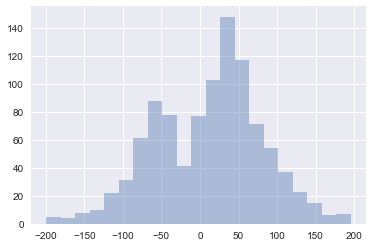

In [96]:
ret_zoom = [(net_pips[i] - net_pips[i-1]) for i in range(2, len(net_pips))]
for i in range(len(ret_zoom)):
    if not -200 < ret_zoom[i] < 200:
        ret_zoom.pop(i)
    if len(ret_zoom) == i + 1:
        break
        
good = 0
bad = 0

for i in range(len(ret_zoom)):
    if ret_zoom[i] >= 8:
        good += 1
    else: bad += 1
        
print('good ratio', good/(good+bad))    

sns.distplot(ret_zoom, kde=False)

count, pip_sum = [0]*2
for i in range(len(net_pips)):
    if net_pips[i] - net_pips[i-1] > 0:
        count += 1
        pip_sum += net_pips[i] - net_pips[i-1]
        
print('average win return', pip_sum/count)

In [ ]:
def ternary_representation(rate_return, threshold, start_index, stop_index):
    ternary_return = []
    for i in range(start_index, stop_index):
        if rate_return[i] >= threshold:
            ternary_return.append(1.)
        elif rate_return[i] <= -threshold:
            ternary_return.append(0.)
        else:
            ternary_return.append(.5)
            
    return ternary_return

ternary_return_1 = ternary_representation(rate_return_1, np.std(rate_return_1[2500:3500]), 0, 3000)
ternary_return_2 = ternary_representation(rate_return_2, np.std(rate_return_2[2500:3500]), 0, 3000)
ternary_return_3 = ternary_representation(rate_return_3, np.std(rate_return_3[2500:3500]), 0, 3000)
'''
print('std_1', np.std(rate_return_1[2500:3500]))
print('std_2', np.std(rate_return_2[2500:3500]))
print('std_3', np.std(rate_return_3[2500:3500]))

plt.figure(figsize=(20, 4))
plt.twinx().plot(rates_1[:100], 'r--')
plt.twinx().plot(rates_2[:100], 'g--')
plt.twinx().plot(rates_3[:100], 'b--')
plt.twinx().plot(ternary_return_1[:100], 'r', alpha=0.7)
plt.twinx().plot(ternary_return_2[:100], 'g', alpha=0.7)
plt.twinx().plot(ternary_return_3[:100], 'b', alpha=0.7)
plt.show()
'''

In [ ]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, Dense, Dropout
from keras.layers.recurrent import LSTM, SimpleRNN, GRU

# Generate data
df = pd.DataFrame(columns=['series_1', 'series_2', 'series_3'])
df_ret_1 = pd.DataFrame(columns=['ternary_ret_rep'])


min_len = min(len(rate_return_1), len(rate_return_2), len(rate_return_3))
train_len = 3000 # Time series length

tr_1 = ternary_representation(rate_return_1, 0.0005, 1000, 4010)
tr_2 = ternary_representation(rate_return_2, 0.0005, 1000, 4010)
tr_3 = ternary_representation(rate_return_3, 0.0001, 1000, 4010)

for i in range(train_len):
    df.loc[i, 'series_1'] = tr_1[i] #rate_return_1[i]
    df.loc[i, 'series_2'] = tr_2[i] #rate_return_2[i]
    df.loc[i, 'series_3'] = tr_3[i] #rate_return_3[i]

# Prepare and format data for training
data = df.values
lookback = 50 # how far back to look
y_shift = 1 # how many steps forward to predict

all_data = [np.expand_dims(np.atleast_2d(data[i:lookback+i, :]), axis=0) for i in range(len(data))]
#
x_train = np.concatenate(np.array(all_data)[-lookback-y_shift, :], axis=0)
#
# use the tail of the series as the test data
'''
df_test = pd.DataFrame(df[-examples:])

test_data = df_test.values
test_input_list = [np.expand_dims(np.atleast_2d(test_data[len(test_data)-lookback:len(test_data), :]), axis=0) for i in range(lookback)]
test_input_mat = np.concatenate(test_input_list, axis=0)
'''
# target - the first column in df dataframe
#target_mat = [np.atleast_2d(ternary_return_1[i+examples:examples+i+y_examples]) for i in range(nb_samples)]
y_train = [tr_1[i+lookback:i+lookback+y_shift] for i in range(1, len(x_train)+1)]
y_train = np.concatenate(y_train, axis=0)

# set up model
features = y_train.shape[2]
hidden = 128

model = Sequential()
model.add(LSTM(hidden, input_shape=(examples, features)))
model.add(Dropout(.2))
model.add(Dense(y_examples))
#model.add(Activation('linear'))
#model.compile(loss='mse', optimizer='rmsprop')
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
hist = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.1)

# Get and plot predicted data and the validation loss
y_predict = model.predict(x_test)  

val_loss_df = pd.DataFrame(hist.history['val_loss'])
val_loss_df.plot()

prediction_df = pd.DataFrame(y_predict).T
prediction_df.columns = ['prediction']
result_df = pd.concat([x_test, prediction_df], ignore_index=True)

'''
plt.figure(figsize=(20, 5))
df_result.plot()
plt.show()
'''

In [ ]:
print(input_mat.shape)
#print(input_mat[:10])
plt.plot(ternary_representation(rate_return_1, 0.0005, 0, 3000)[:100])
plt.plot(ternary_representation(rate_return_2, 0.0005, 0, 3000)[:100])
plt.plot(ternary_representation(rate_return_3, 0.0001, 0, 3000)[:100])

In [ ]:
plt.plot(rate_return_1[2999:3010])
plt.plot(rate_return_2[2999:3010])
plt.plot(rate_return_3[2999:3010])

In [ ]:
df_result[-10:].plot()

In [ ]:
%matplotlib
from mpl_toolkits.mplot3d import Axes3D

rate_return_ma_1 = [sum(rate_return_1[i-ma_p:i])/ma_p for i in range(ma_p, len(rate_return_1))]
rate_return_ma_2 = [sum(rate_return_2[i-ma_p:i])/ma_p for i in range(ma_p, len(rate_return_2))]
rate_return_ma_3 = [sum(rate_return_3[i-ma_p:i])/ma_p for i in range(ma_p, len(rate_return_3))]

rr1 = []
rr2 = []
rr3 = []

for i in range(min(len(rate_return_ma_1), len(rate_return_ma_2), len(rate_return_ma_3))):
    if (-0.005 < rate_return_ma_1[i] < 0.005 and 
        -0.005 < rate_return_ma_2[i] < 0.005 and 
        -0.005 < rate_return_ma_3[i] < 0.005):
        rr1.append(rate_return_ma_1[i])
        rr2.append(rate_return_ma_2[i])
        rr3.append(rate_return_ma_3[i])
        
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rr1[:10000], rr2[:10000], zs=rr3[:10000], zdir='z', s=20, cmap='viridis', depthshade=True)
#ax.contourf(rate_return_1[:1000], rate_return_2[:1000], Z=rate_return_3[:1000], zdir='z')
ax.set_xlabel('USD-ret')
ax.set_ylabel('AUD-ret')
ax.set_zlabel('CHF-ret')
plt.title('EUR-pairs')
plt.show()

In [ ]:
#%matplotlib inline
'''
plt.figure(figsize=(35, 4))
plt.plot(trade_data[0]) # trade return (pips)
plt.twinx().plot(trade_data[1], 'r') # symbol return
plt.twinx().plot(trade_data[2], 'g') # weekly std
plt.show()
'''
%matplotlib
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trade_data[0], trade_data[1], zs=trade_data[2], zdir='z', s=20, c=None, depthshade=True)
#ax.contourf(rate_return_1[:1000], rate_return_2[:1000], Z=rate_return_3[:1000], zdir='z')
ax.set_xlabel('trade-ret')
ax.set_ylabel('symbol-ret')
ax.set_zlabel('std[-500:]')
plt.show()

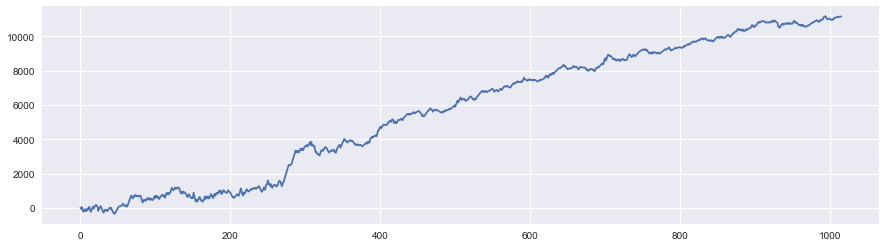

In [93]:
plt.figure(figsize=(15, 4))
plt.plot(net_pips)
plt.show()

pd.DataFrame(net_pips).to_csv('EURAUD-net_2.csv')

178.4518750000002


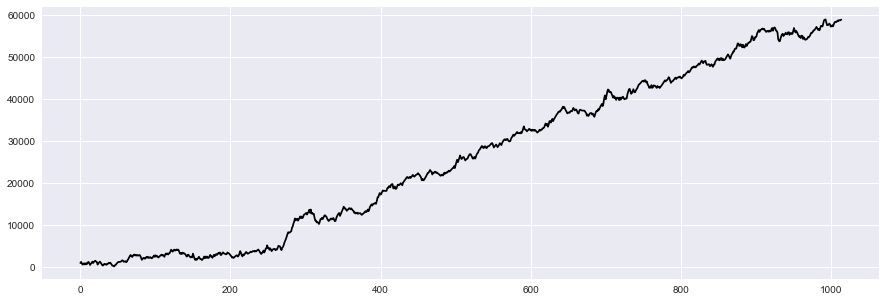

In [94]:
boosted_net = [1000]
for i in range(2, len(net_pips)):
    boosted_net.append(boosted_net[-1] + 0.0005*(net_pips[i-1] + 5000)*(net_pips[i] - net_pips[i-1]))

print(min(boosted_net))
    
ret50 = [(boosted_net[i] - boosted_net[i-50])/boosted_net[i-50] for i in range(200, len(boosted_net))]
for i in range(200):
    ret50.insert(0, 0)

plt.figure(figsize=(15, 5))
plt.plot(boosted_net, 'k')
#plt.twinx().plot(ret50, 'r')
plt.show()

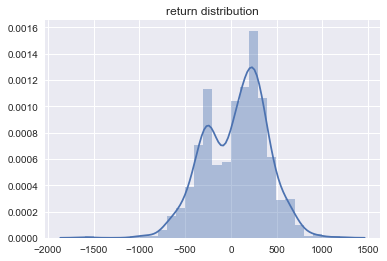

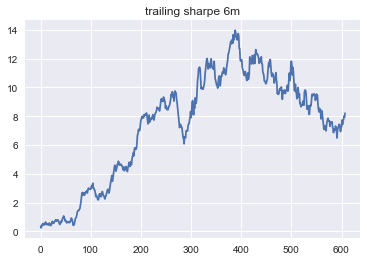

std		 336.219814917
stdmax		 3.55 deviations
mean		 56.9179326259
median		 108.08925
skewness	 -0.30121
kurtosis	 0.17385223768864622
win rate	 0.6134122287968442
mean sharpe	 7.341613289
current sharpe	 8.20852839214
Using matplotlib backend: Qt5Agg


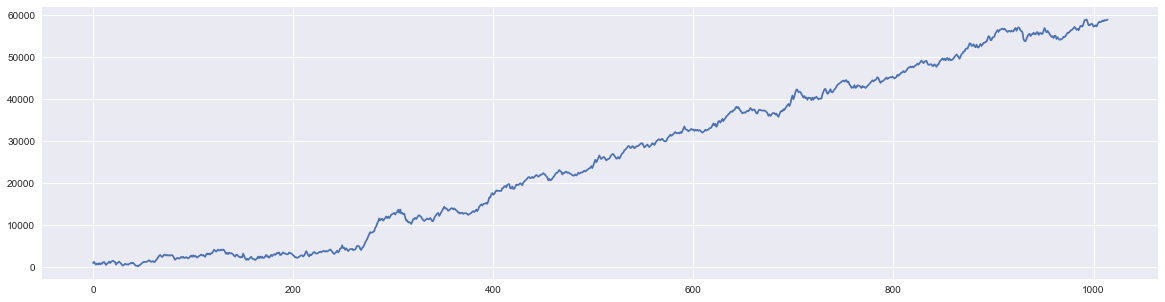

In [95]:
distribution_sheet(boosted_net, 2.5)
%matplotlib
plt.figure(figsize=(20, 5))
plt.plot(boosted_net)
plt.show()